In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import matplotlib.pyplot as plt

d:\Users\10252\anaconda3\envs\ERC\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def data_processing(filename,embedding_n,padding = -1):
    dataset = pd.read_json(filename)
    max_n = 0
    n_x = dataset.shape[1]
    for t in dataset:
        n = len(dataset[t][0])
        # print(len(dataset[t][0][0]), end = " ")#  all 300
        # print(n, end = " ") #2 3 9 8 1 6 2 6 4 3 2 3 5 4 4 4 7 1 12 4 5 1 5 5 4 3 3 5 12 13 11 6 4 5 2 4 11 7 4 4 10 2 2 3 4 6 1 4 6 5 5 6 3 6 9 6 9 6 1 12 6 6 10 3 8 6 8 5 9 14 4 6 3 3 5 4 8 5 9 5 10 3 3 1 1 7 5 6
        if n>max_n:
            max_n = n
    if (padding == -1):
        output = torch.zeros((n_x, max_n, embedding_n))
    else:
        output = torch.zeros((n_x, padding, embedding_n))
    for i in dataset:
        t = torch.tensor(dataset[i][0])
        # print(t.shape)
        output[i, :t.shape[0], :] = t
    return output

In [ ]:
def len_limit(filename):
    dataset = pd.read_json(filename)
    max_n = 0
    n_x = dataset.shape[1]
    for t in dataset:
        n = len(dataset[t][0])
        # print(len(dataset[t][0][0]), end = " ")#  all 300
        # print(n, end = " ") #2 3 9 8 1 6 2 6 4 3 2 3 5 4 4 4 7 1 12 4 5 1 5 5 4 3 3 5 12 13 11 6 4 5 2 4 11 7 4 4 10 2 2 3 4 6 1 4 6 5 5 6 3 6 9 6 9 6 1 12 6 6 10 3 8 6 8 5 9 14 4 6 3 3 5 4 8 5 9 5 10 3 3 1 1 7 5 6
        if n>max_n:
            max_n = n

In [3]:
train_label = pd.read_csv("train_split.csv").loc[0:34876]
test_label = pd.read_csv("train_split.csv").loc[34877:35831]
valid_label = pd.read_csv("train_split.csv").loc[38506:39594]
print(train_label["Sentiment"].value_counts())
print(test_label["Sentiment"].value_counts())
print(valid_label["Sentiment"].value_counts())
emotions = list(train_label["Sentiment"].value_counts().index)
emotion2int = dict((emotions[i], i) for i in range(len(emotions)))
typecount = len(emotions)
train_label["EmotionID"] = train_label["Sentiment"].apply(lambda x: emotion2int[x])
test_label["EmotionID"] = test_label["Sentiment"].apply(lambda x: emotion2int[x])
valid_label["EmotionID"] = valid_label["Sentiment"].apply(lambda x: emotion2int[x])
print(emotion2int)


negative    19150
neutral     10185
positive     5542
Name: Sentiment, dtype: int64
negative    404
neutral     320
positive    231
Name: Sentiment, dtype: int64
neutral     470
negative    416
positive    203
Name: Sentiment, dtype: int64
{'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
Dia_train = torch.Tensor(train_label["EmotionID"])
Dia_test = torch.Tensor(test_label["EmotionID"].reset_index(drop=True))
Dia_valid = torch.Tensor(valid_label["EmotionID"].reset_index(drop=True))

In [214]:
X_train = data_processing("smallX.json",300) 
train_n, max_n, embedding_n = X_train.shape[0], X_train.shape[1], X_train.shape[2]

print(X_train.shape)
X_test = data_processing("testX.json",300, max_n) 

test_n = X_test.shape[0]
print(X_test.shape)
X_valid = data_processing("validX.json",300, max_n) 

print(X_valid.shape)

torch.Size([34877, 34, 300])
torch.Size([955, 34, 300])
torch.Size([1089, 34, 300])


In [215]:
# for i in range(10):
#     print(X_train[i])

In [217]:
Y_train = torch.Tensor(train_label["EmotionID"])
print(Y_train[:100])
Y_test = torch.Tensor(test_label["EmotionID"].reset_index(drop=True))
Y_valid = torch.Tensor(valid_label["EmotionID"].reset_index(drop=True))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 1.])


In [218]:
import random


def downsample(x, y, num_samples = 5000):
    new_x = []
    new_y = []

    for label in range(3):
        label_idx = torch.where(y == label)[0]
        selected_idx = random.sample(list(label_idx), num_samples)
        new_x.append(x[selected_idx])
        new_y.append(y[selected_idx])

    new_x = torch.cat(new_x)
    new_y = torch.cat(new_y)
    

    return new_x, new_y

In [219]:
X_train_sampled, Y_train_sampled = downsample(X_train, Y_train)

In [220]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [221]:
def torch2tf(pytorch_tensor): 
    # As we decided to use PyTorch at first 
    # the output is a Torch tensor 
    # so we need to change it to Tensorflow tensor
    numpy_array = pytorch_tensor.numpy()
    tensorflow_tensor = tf.convert_to_tensor(numpy_array)
    return tensorflow_tensor

In [222]:
X_train = torch2tf(X_train_sampled)
print(X_train.shape)
Y_train = torch2tf(Y_train_sampled)
Y_train = tf.one_hot(tf.cast(Y_train, dtype=tf.uint8), depth=typecount)
print(Y_train.shape)
X_test = torch2tf(X_test)
print(X_test.shape)
Y_test = torch2tf(Y_test)
Y_test = tf.one_hot(tf.cast(Y_test, dtype=tf.uint8), depth=typecount)
print(Y_test.shape)
X_valid = torch2tf(X_valid)
print(X_valid.shape)
Y_valid = torch2tf(Y_valid)
Y_valid = tf.one_hot(tf.cast(Y_valid, dtype=tf.uint8), depth=typecount)
print(Y_valid.shape)

(15000, 34, 300)
(15000, 3)
(955, 34, 300)
(955, 3)
(1089, 34, 300)
(1089, 3)


In [223]:
print(X_train[0], Y_train[0])
print(X_train[1], Y_train[1])
print(X_train[5000], Y_train[5000])
print(X_train[5001], Y_train[5001])
print(X_train[10000], Y_train[10000])
print(X_train[10001], Y_train[10001])

tf.Tensor(
[[ 0.10587868  0.08353671  0.40713635 ... -0.06809028 -0.03874565
  -0.0266461 ]
 [ 0.01800424  0.06060464  0.46984264 ... -0.09499851  0.09012631
  -0.01534141]
 [-0.14193174  0.07036281  0.4525549  ... -0.00449586 -0.0591675
  -0.06273507]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(34, 300), dtype=float32) tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor(
[[ 1.5882351e-02  4.9454134e-02  3.9728960e-01 ...  1.1873303e-02
   1.5091806e-02 -1.4744475e-01]
 [-5.8672681e-02  5.8034444e-03  3.2536876e-01 ... -1.2298434e-01
  -2.1377228e-02 -8.5676298e-02]
 [-4.0085413e-02  6.7821480e-02  4.5619148e-01 ... -5.8259200e-02
  -3.9267991e-04 -4.1808520e-02]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e

In [240]:
import keras
from keras.layers import LSTM, Dense, Activation, Masking, TimeDistributed, Bidirectional, BatchNormalization
from keras.models import Sequential
from keras.utils import plot_model

In [241]:
h_n = embedding_n
epochs = 100
callbacks = [
    keras.callbacks.ModelCheckpoint("checkpoint/save_at_{epoch}.keras"),
#     keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0,
#     patience=10,
#     verbose=0,
#     mode="auto",
#     baseline=None,
#     restore_best_weights=False,
# )
]

In [242]:
def make_model(input_shape, h_n=300, num_classes=13):
    inputs = keras.Input(shape=input_shape, name="Input_layer")
    masked = Masking(0,name="Shapeshifter")(inputs)
    tmp = LSTM(1000, dropout=0.5,  name="LSTM_layer", activation="tanh")(masked)
    bn = BatchNormalization()(tmp)
    # tmp1 = Dense(300, activation="softmax", name="Hidden_layer")(tmp)
    outputs = Dense(num_classes, activation="softmax", name="Output_layer")(bn)
    return keras.Model(inputs, outputs)

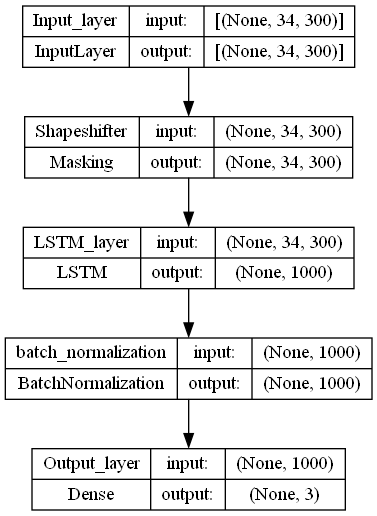

In [243]:
model = make_model(input_shape=(34,300), num_classes=typecount)
plot_model(model, show_shapes=True)

In [244]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [245]:
model.fit(
    X_train,Y_train,
    epochs=epochs,
    callbacks=callbacks,
    batch_size=50,
    shuffle=True,
    validation_data=(X_valid,Y_valid)
)

Epoch 1/100
300/300 [==============================] - 9s 24ms/step - loss: 1.2427 - accuracy: 0.3901 - val_loss: 1.0747 - val_accuracy: 0.4555
Epoch 2/100
300/300 [==============================] - 6s 20ms/step - loss: 1.0682 - accuracy: 0.4285 - val_loss: 1.0440 - val_accuracy: 0.4775
Epoch 3/100
300/300 [==============================] - 6s 21ms/step - loss: 1.0564 - accuracy: 0.4474 - val_loss: 1.0689 - val_accuracy: 0.4408
Epoch 4/100
300/300 [==============================] - 6s 20ms/step - loss: 1.0490 - accuracy: 0.4459 - val_loss: 1.0707 - val_accuracy: 0.4270
Epoch 5/100
300/300 [==============================] - 7s 22ms/step - loss: 1.0477 - accuracy: 0.4505 - val_loss: 1.0784 - val_accuracy: 0.4298
Epoch 6/100
300/300 [==============================] - 6s 21ms/step - loss: 1.0413 - accuracy: 0.4545 - val_loss: 1.0613 - val_accuracy: 0.4500
Epoch 7/100
300/300 [==============================] - 7s 23ms/step - loss: 1.0367 - accuracy: 0.4675 - val_loss: 1.0852 - val_accuracy:

KeyboardInterrupt: 